## Main Task
Building a Game Recommendation System with Steam Platform Data!

### Data Understanding
The dataset contains over 41 million cleaned and preprocessed user recommendations (reviews) from a Steam Store - a leading online platform for purchasing and downloading video games, DLC, and other gaming-related content.  
Additionally, it contains detailed information about games and add-ons.  

The dataset consists of three main entities:

1. **games.csv** - a table of games (or add-ons) information on ratings, pricing in US dollars $, release date, etc. A piece of extra non-tabular details on games, such as descriptions and tags, is in a metadata file;
2. **users.csv** - a table of user profiles' public information: the number of purchased products and reviews published;
3. **recommendations.csv** - a table of user reviews: whether the user recommends a product. The table represents a many-many relation between a game entity and a user entity.

The dataset does not contain any personal information about users on a Steam Platform. A preprocessing pipeline anonymized all user IDs. All collected data is accessible to a member of the general public.

Link to the dataset: [https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam/data]

In [10]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
games_df = pd.read_csv('datasets/games.csv')
users_df = pd.read_csv('datasets/users.csv')
recommendations_df = pd.read_csv('datasets/recommendations.csv')

In [3]:
games_df.head(2)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True


In [4]:
users_df.head(2)

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1


In [5]:
recommendations_df.head(2)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1


### Data PreProcessing

In [6]:
games_df.isnull().sum()

app_id            0
title             0
date_release      0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
dtype: int64

In [7]:
users_df.isnull().sum()

user_id     0
products    0
reviews     0
dtype: int64

In [8]:
recommendations_df.isnull().sum()

app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
dtype: int64

### EDA on Games Dataset
#### What is the distribution of game ratings?

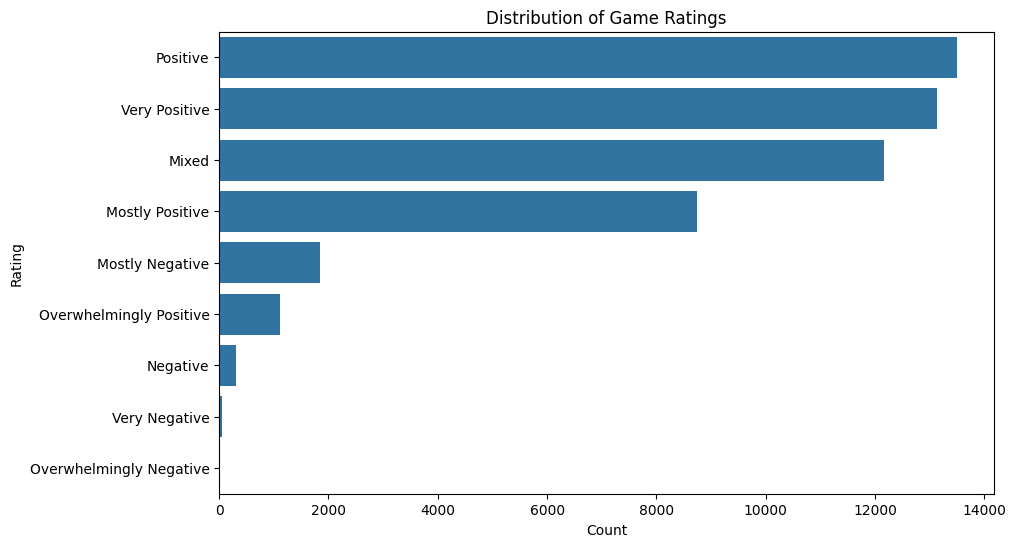

In [12]:
# Count plot for game ratings
plt.figure(figsize=(10, 6))
sns.countplot(y=games_df['rating'], order=games_df['rating'].value_counts().index)
plt.title('Distribution of Game Ratings')
plt.xlabel('Count')
plt.ylabel('Rating')
plt.show()

> 'Posivie', 'Very Positive', 'Mixed' and 'Mostly Positive' are the top 3 Ratings groups! The distribution becomes very low for 'Mostly Negative', 'Overwhelmingly Positive', 'Negative', 'Very Negative'! The 'Overwhelmingly Negative' is zero.

#### What is the distribution of Final Price of games?

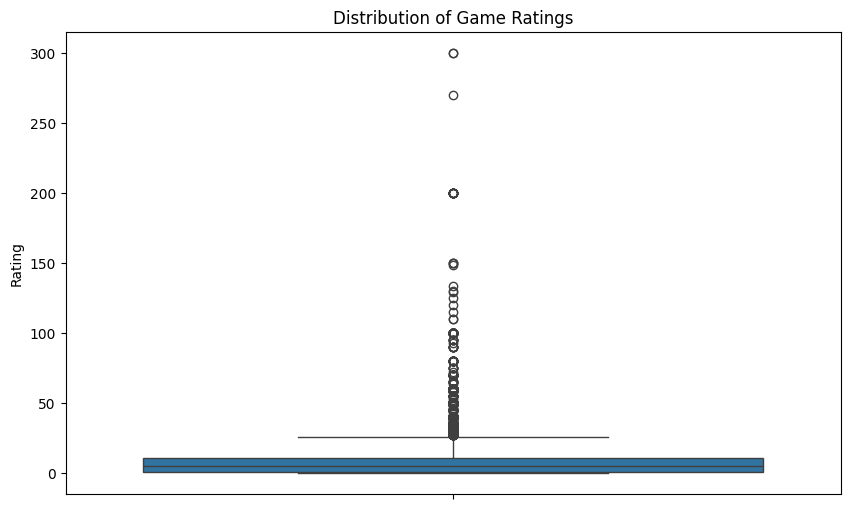

In [19]:
# Boxplot for game ratings
plt.figure(figsize=(10, 6))
sns.boxplot(y=games_df['price_final'])
plt.title('Distribution of Game Ratings')
plt.ylabel('Rating')
plt.show()


> The price range is between 0-12 USD, based on experience we change the range for Final_Price to 0 - 50 USD
#### How do the prices (both final and original) of games vary across different levels of ratings?

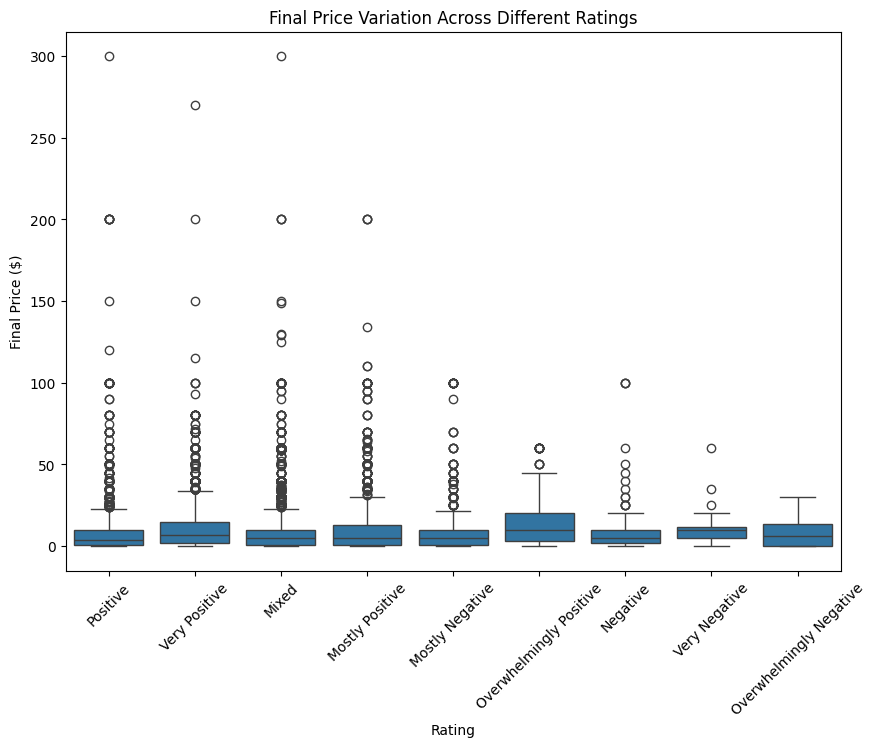

In [18]:
# Boxplot for final prices based on ratings
plt.figure(figsize=(10, 7))
sns.boxplot(x='rating', y='price_final', data=games_df, order=games_df['rating'].value_counts().index)
plt.title('Final Price Variation Across Different Ratings')
plt.xlabel('Rating')
plt.ylabel('Final Price ($)')
plt.xticks(rotation=45)
plt.show()

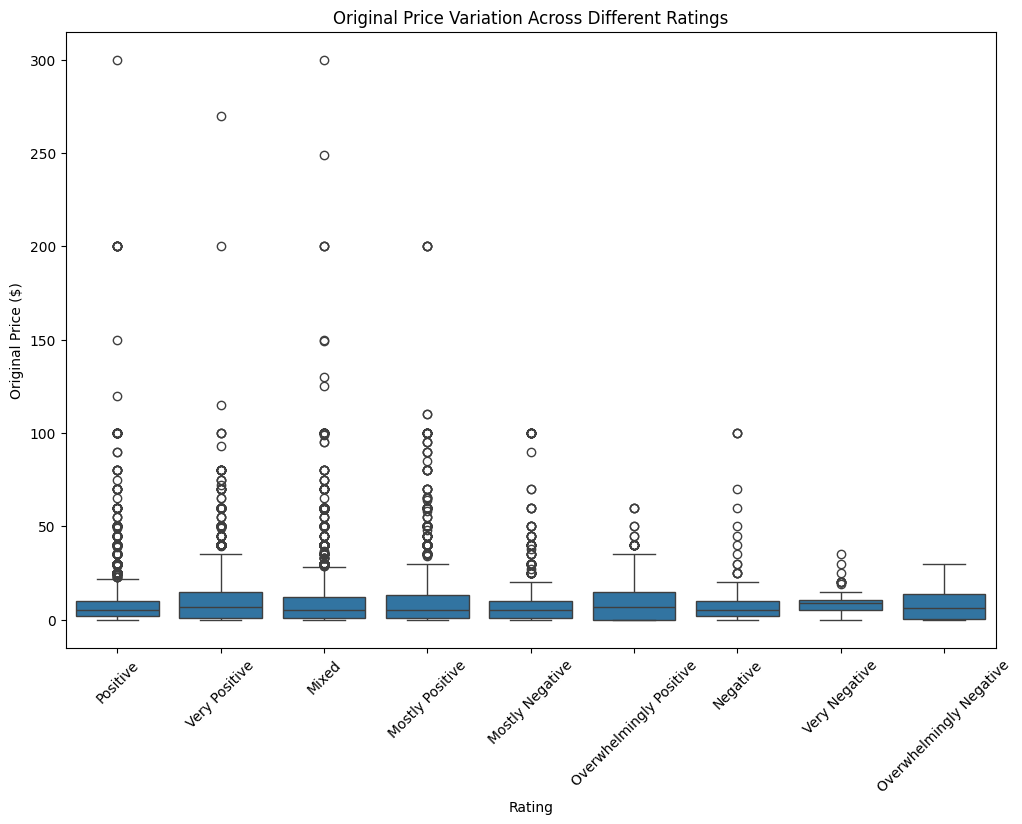

In [15]:
# Boxplot for original prices based on ratings
plt.figure(figsize=(12, 8))
sns.boxplot(x='rating', y='price_original', data=games_df, order=games_df['rating'].value_counts().index)
plt.title('Original Price Variation Across Different Ratings')
plt.xlabel('Rating')
plt.ylabel('Original Price ($)')
plt.xticks(rotation=45)
plt.show()

#### Are there any patterns or trends in the release dates of games?

#### What proportion of games are available on Windows, Mac, and Linux platforms?

#### How does the positive_ratio correlate with the number of user_reviews?

#### What are the discount patterns and how do they relate to the game's rating and sales performance?

#### How many games are compatible with Steam Deck, and what are their ratings and prices?

#### Are there any significant outliers or anomalies in terms of pricing, ratings, release dates, or user reviews?